In [88]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
from matplotlib import colors

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
import cv2

from scipy import ndimage, fft

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

#### Experiment #1 : HandCrafted AntiSymmetric Bipolar Convolution


In [89]:
k = 20 # Top 10% highest l2-magnitude filters

(3, 3, 2, 2)


NameError: name 'l_num' is not defined

c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.


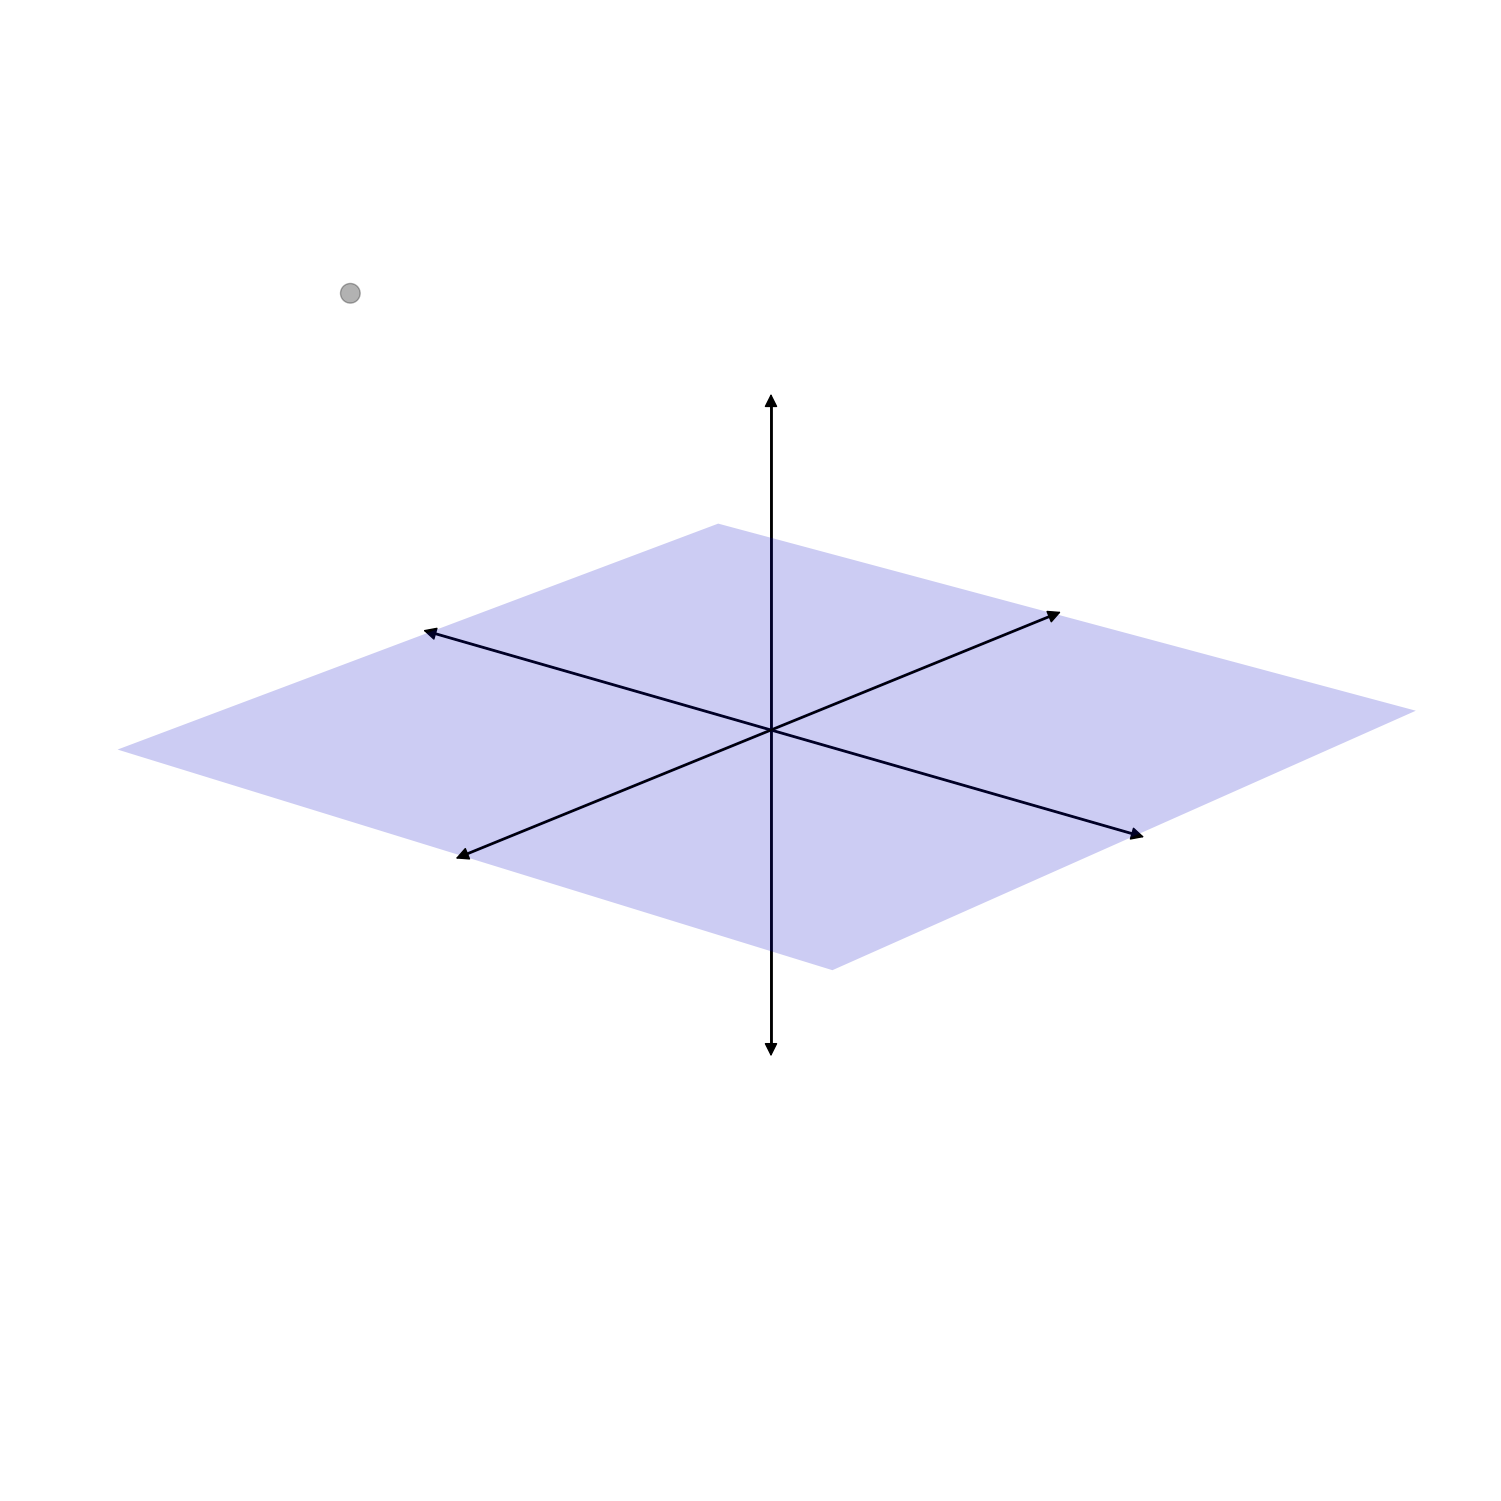

In [93]:
F = 1

filters = np.zeros((3,3,2,2))
filters[:,:,0,0] = (1/6)*np.array([[1,1,1], [0,0,0], [-1,-1,-1]]) +  (1/9)*np.array([[1,1,1], [1,1,1], [1,1,1]]) 
filters[:,:,1,0] = ((-1/6)*np.array([[1,1,1], [0,0,0], [-1,-1,-1]]) + (-2/9)*np.array([[1,1,1], [1,1,1], [1,1,1]]))

filters[:,:,0,1] = ((1/6)*np.array([[1,1,1], [0,0,0], [-1,-1,-1]]) +  (-2/9)*np.array([[1,1,1], [1,1,1], [1,1,1]]))
filters[:,:,1,1] = (-1/6)*np.array([[1,1,1], [0,0,0], [-1,-1,-1]]) +  (1/9)*np.array([[1,1,1], [1,1,1], [1,1,1]]) 

theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)

a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])
mag = reduce_euclidean_norm(filters, axis=[0,1])


x =(a_mag[:,F]*np.cos((theta[:,F]))).numpy()
y =( a_mag[:,F]*np.sin((theta[:,F]))).numpy()
z =(s_mag[:,F]*np.sign(np.mean(s, axis=(0,1)))[:,F]).numpy()
plt.rcParams.update({'figure.dpi': '100'})


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        return np.min(zs)

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

# Create a new figure and a 3D axis
fig = plt.figure(figsize=(15, 15),constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')

# Remove the panes (walls)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Remove the pane lines
ax.xaxis.pane.set_edgecolor('none')
ax.yaxis.pane.set_edgecolor('none')
ax.zaxis.pane.set_edgecolor('none')

# Remove grid lines
ax.grid(False)

# Remove default tick marks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Create the axes lines
axis_length = 10
ax.plot([-1, 1], [0, 0], [0, 0], 'k-', linewidth=2)  # x-axis
ax.plot([0, 0], [-1, 1], [0, 0], 'k-', linewidth=2)  # y-axis
ax.plot([0, 0], [0, 0], [-1, 1], 'k-', linewidth=2)  # z-axis

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set the limits for each axis
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

arrow_prop_dict = dict(mutation_scale=20, arrowstyle='<|-|>', shrinkA=0, shrinkB=0)


    
a = Arrow3D([- 1.02, 1.02], [0, 0], [0, 0], **arrow_prop_dict, color='k')
ax.add_artist(a)
a = Arrow3D( [0, 0],[- 1.02, 1.02], [0, 0], **arrow_prop_dict, color='k')
ax.add_artist(a)
a = Arrow3D([0, 0], [0, 0],[-1.02, 1.02], **arrow_prop_dict, color='k')
ax.add_artist(a)


# Color the x,y plane
xx, yy = np.meshgrid(range(-1, 2), range(-1, 2))
ax.plot_surface(xx, yy, np.zeros_like(xx), alpha=0.2, color='blue') 
# Add text to the x,y plane
#ax.text(0, 0, 0, "X-Y Plane", fontsize=14, ha='center', va='center', 
#        zdir='x', zorder=20)# Example: Plot some 3D points
points = np.array([x,y,z]).T*3
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='k', s=200)
plt.axis('off')
# Show the plot

ax.view_init(elev=20, azim=40)

fig.savefig(f'hand_L{l_num}_f{F}_mixed_bipol_plus_minus.pdf', dpi=600,  transparent=True, bbox_inches='tight')
plt.show()

import subprocess
subprocess.run(["pdfcrop ", f'hand_L{l_num}_f{F}_mixed_bipol_plus_minus.pdf']) 


In [91]:
#var = 2/(128*9)

img =  cv2.imread('input4.png', 0)/255. 
#img = (img-np.mean(img))/np.std(img)
#img = tf.repeat(tf.expand_dims([img], axis=-1) , repeats = 512, axis=-1)  #get_double_slit(shape) , axis=0)
print(img.shape)

(224, 224)


In [5]:
np.var(img), 1/(128*9)


(0.023040123255935026, 0.0008680555555555555)

(3, 3, 2, 2)
(1, 224, 224, 2)
0


c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


(1, 224, 224, 2)
1
(1, 224, 224, 2)
2
(1, 224, 224, 2)
3
(1, 224, 224, 2)
4
(1, 224, 224, 2)
5
(1, 224, 224, 2)
6
(1, 224, 224, 2)
7
(1, 224, 224, 2)
8
(1, 224, 224, 2)
9
(1, 224, 224, 2)
10
(1, 224, 224, 2)
11
(1, 224, 224, 2)
12
(1, 224, 224, 2)
13
(1, 224, 224, 2)
14
(1, 224, 224, 2)
15
(1, 224, 224, 2)
16
(1, 224, 224, 2)
17
(1, 224, 224, 2)
18
(1, 224, 224, 2)
19
(1, 224, 224, 2)
20


c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(1, 224, 224, 2)
21
(1, 224, 224, 2)
22
(1, 224, 224, 2)
23
(1, 224, 224, 2)
24
(1, 224, 224, 2)
25
(1, 224, 224, 2)
26
(1, 224, 224, 2)
27
(1, 224, 224, 2)
28
(1, 224, 224, 2)
29
(1, 224, 224, 2)
30
(1, 224, 224, 2)
31
(1, 224, 224, 2)
32
(1, 224, 224, 2)
33
(1, 224, 224, 2)
34
(1, 224, 224, 2)
35
(1, 224, 224, 2)
36
(1, 224, 224, 2)
37
(1, 224, 224, 2)
38
(1, 224, 224, 2)
39
(1, 224, 224, 2)
40
(1, 224, 224, 2)
41
(1, 224, 224, 2)
42
(1, 224, 224, 2)
43
(1, 224, 224, 2)
44
(1, 224, 224, 2)
45
(1, 224, 224, 2)
46
(1, 224, 224, 2)
47
(1, 224, 224, 2)
48
(1, 224, 224, 2)
49
(1, 224, 224, 2)
50
(1, 224, 224, 2)
51
(1, 224, 224, 2)
52
(1, 224, 224, 2)
53
(1, 224, 224, 2)
54
(1, 224, 224, 2)
55
(1, 224, 224, 2)
56
(1, 224, 224, 2)
57
(1, 224, 224, 2)
58
(1, 224, 224, 2)
59
(1, 224, 224, 2)
60
(1, 224, 224, 2)
61


KeyboardInterrupt: 

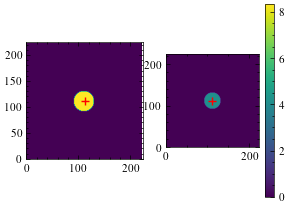

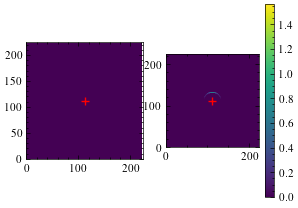

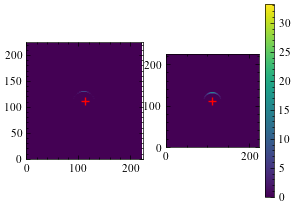

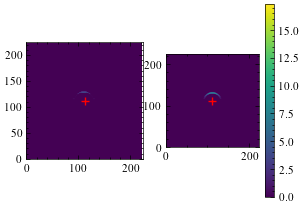

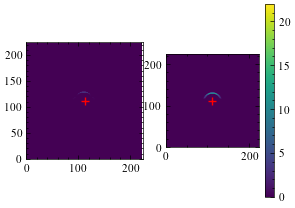

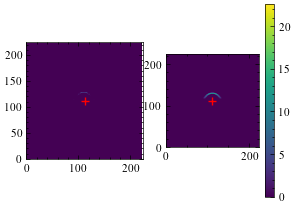

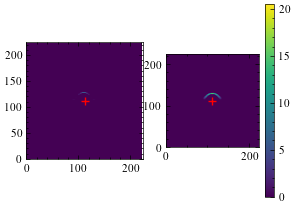

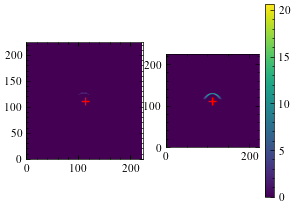

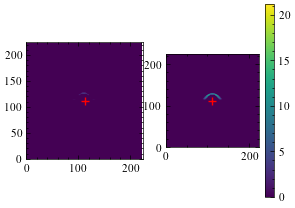

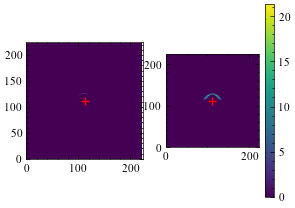

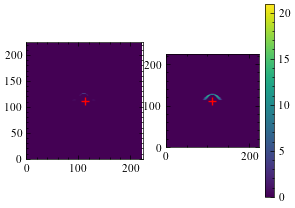

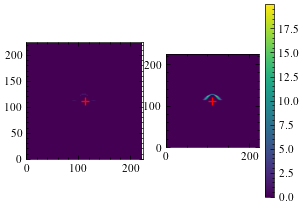

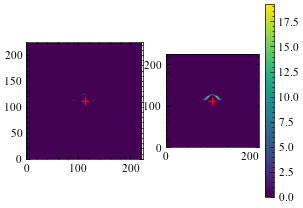

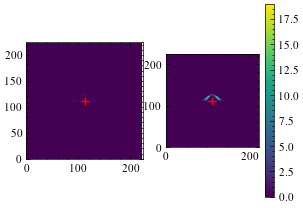

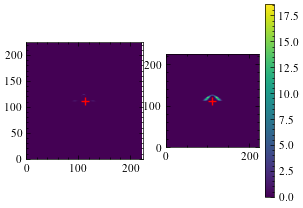

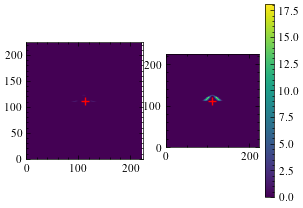

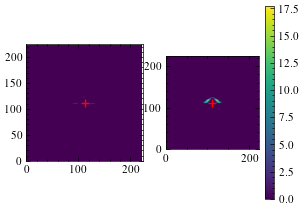

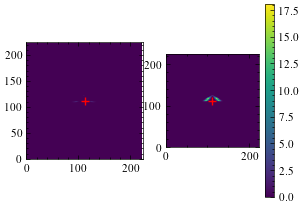

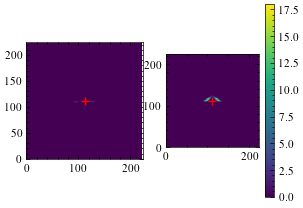

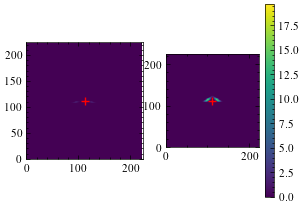

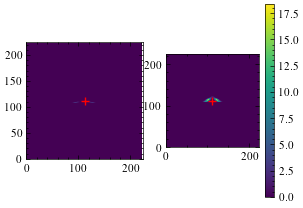

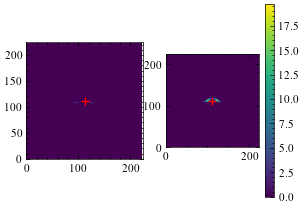

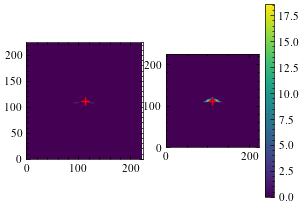

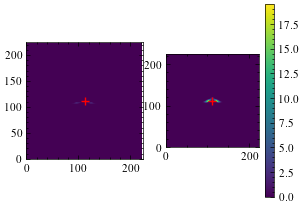

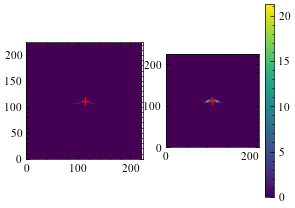

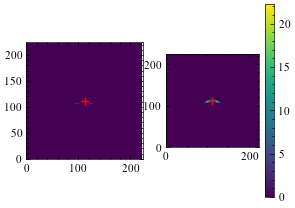

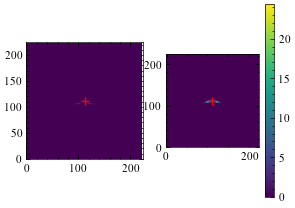

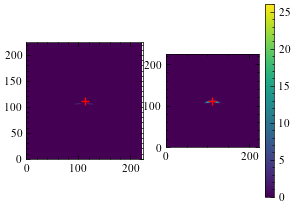

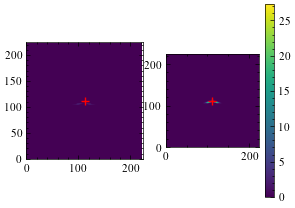

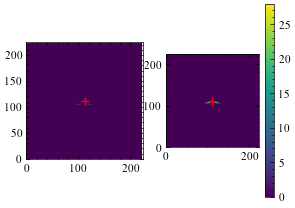

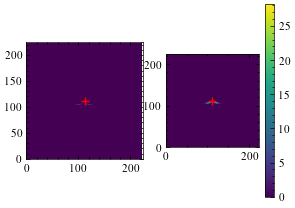

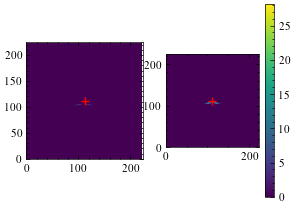

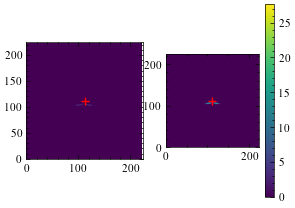

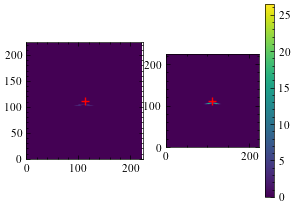

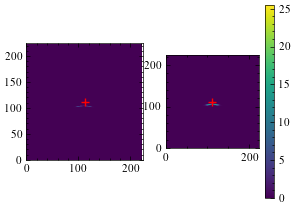

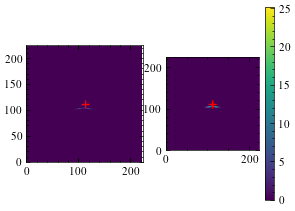

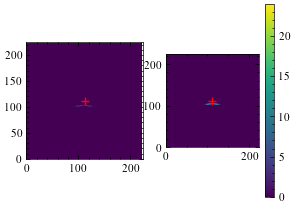

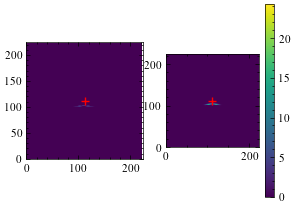

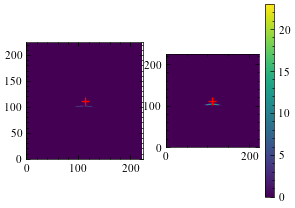

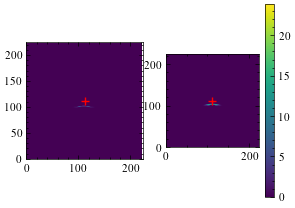

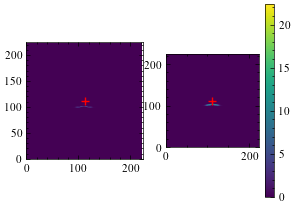

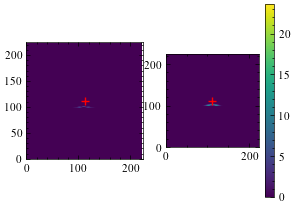

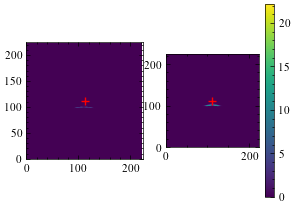

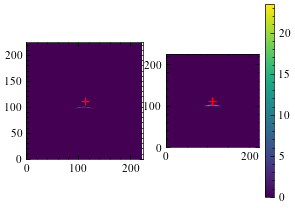

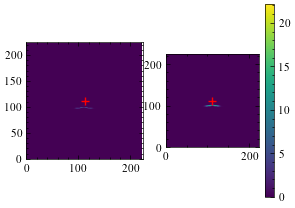

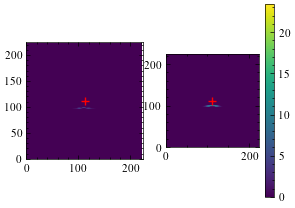

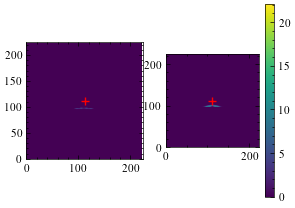

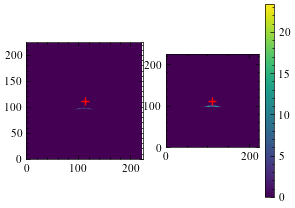

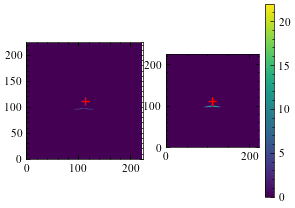

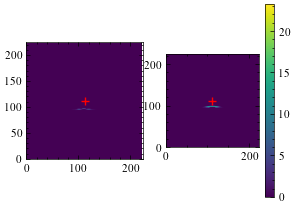

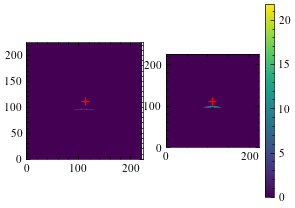

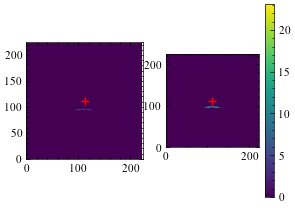

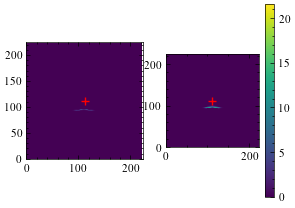

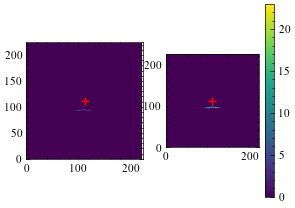

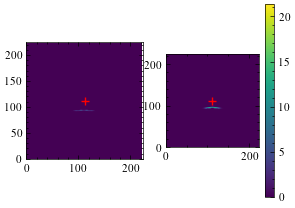

Error in callback <function flush_figures at 0x00000272A125F048> (for post_execute):


KeyboardInterrupt: 

In [94]:
w =tf.cast(filters, dtype=tf.float32) # tf.expand_dims(filters, -1), dtype=tf.float32)
print(w.shape)

x1 = img
x2 = img * 0.5


directory = f"figures/hand_mixed_bipolar_plus_minus"
if not os.path.exists(directory):
	os.makedirs(directory)
x = tf.cast(tf.expand_dims(tf.stack([x1, x2], axis=-1), axis=0), dtype=tf.float32) 
x = x/np.std(x)

print(x.shape)
for i in range(200):
	print(i)

	images = []
	fig, ax = plt.subplots(1, 2)


	norm = colors.Normalize(vmin=np.min(x), vmax=np.max(x))

	images.append(ax[0].imshow(x[0,:,:,0], norm=norm))

	images.append(ax[1].imshow(x[0,:,:,1], norm=norm))
	ax[ 0].plot(112, 112, marker = '+', color='red')
	ax[0].set(xlim=(0, 224), ylim=(0, 224))
	ax[1].plot(112, 112, marker = '+', color='red')
	ax[1].set(xlim=(0, 224), ylim=(0, 224))


	fig.colorbar(images[0], orientation='vertical')

	fig.savefig(directory + f'/{i}.pdf', dpi=600,  transparent=True)



	x = tf.nn.conv2d(x, w , strides=(1,1), 
							padding='SAME') 
	x = x/np.std(x)

	x = tf.nn.relu( x)

	#x = tf.repeat(x , repeats = filters.shape[-2], axis=-1)
	print(x.shape)




